In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('Microsoft_Stock_Clean.csv')

In [3]:
df

,Date,Open,High,Low,Close,Volume,Average,Net
0,2015-04-01,40.60,40.76,40.31,40.72,36865322,40.53,0.12
1,2015-04-02,40.66,40.74,40.12,40.29,37487476,40.43,-0.37
2,2015-04-03,40.66,40.74,40.12,40.29,37487476,40.43,-0.37
3,2015-04-04,40.66,40.74,40.12,40.29,37487476,40.43,-0.37
4,2015-04-05,40.66,40.74,40.12,40.29,37487476,40.43,-0.37
...,...,...,...,...,...,...,...,...
2187,2021-03-27,231.55,236.71,231.55,236.48,25479853,234.13,4.93
2188,2021-03-28,231.55,236.71,231.55,236.48,25479853,234.13,4.93
2189,2021-03-29,236.59,236.80,231.88,235.24,25227455,234.34,-1.35
2190,2021-03-30,233.53,233.85,231.10,231.85,24792012,232.48,-1.68


In [4]:
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

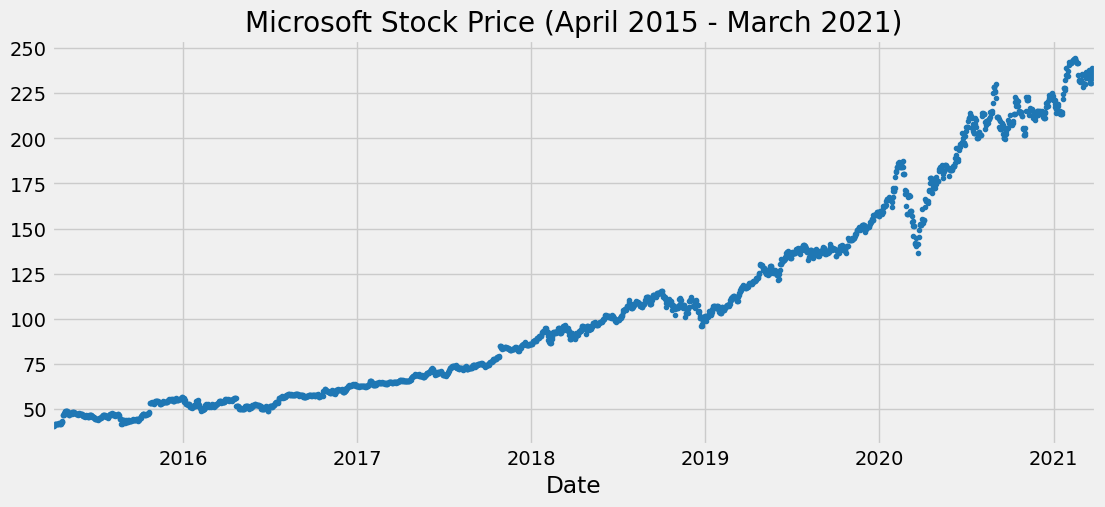

In [5]:
df['Average'].plot(style='.', figsize=(12, 5), color=color_pal[0], title='Microsoft Stock Price (April 2015 - March 2021)')
plt.show()

# Outlier Analysis

<Axes: ylabel='Frequency'>

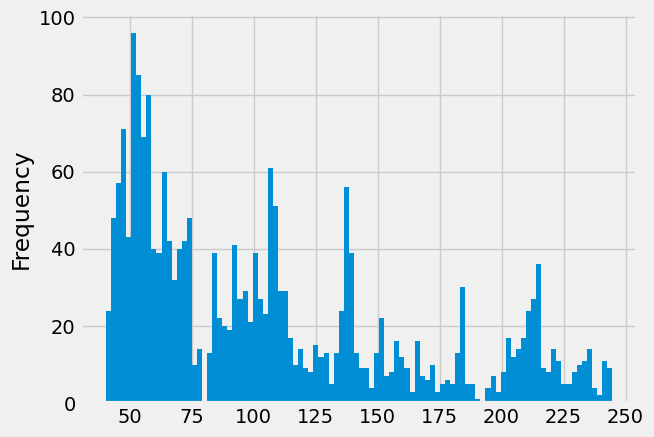

In [6]:
df['Average'].plot(kind='hist', bins=100)

# Time Series Cross Validation

In [7]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=180, gap=1)
df = df.sort_index()

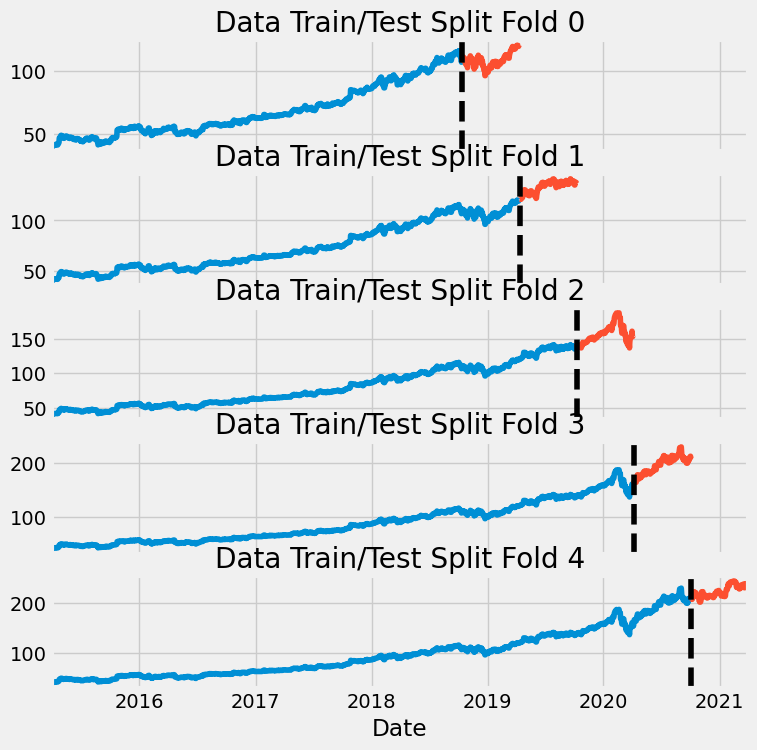

In [8]:
fig, axs = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Average'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Average'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Feature Creation (Date Features and Lags)

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [10]:
def add_lags(df):
    target_map = df['Average'].to_dict()
    df['lag6'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    df['lag12'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag18'] = (df.index - pd.Timedelta('424 days')).map(target_map)
    return df

df = add_lags(df)

In [11]:
df

,Open,High,Low,Close,Volume,Average,Net,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag6,lag12,lag18
Date,,,,,,,,,,,,,,,,,
2015-04-01,40.60,40.76,40.31,40.72,36865322,40.53,0.12,2,2,4,2015,91,1,14,NaN,NaN,NaN
2015-04-02,40.66,40.74,40.12,40.29,37487476,40.43,-0.37,3,2,4,2015,92,2,14,NaN,NaN,NaN
2015-04-03,40.66,40.74,40.12,40.29,37487476,40.43,-0.37,4,2,4,2015,93,3,14,NaN,NaN,NaN
2015-04-04,40.66,40.74,40.12,40.29,37487476,40.43,-0.37,5,2,4,2015,94,4,14,NaN,NaN,NaN
2015-04-05,40.66,40.74,40.12,40.29,37487476,40.43,-0.37,6,2,4,2015,95,5,14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,231.55,236.71,231.55,236.48,25479853,234.13,4.93,5,1,3,2021,86,27,12,210.32,152.04,164.42
2021-03-28,231.55,236.71,231.55,236.48,25479853,234.13,4.93,6,1,3,2021,87,28,12,208.44,152.04,167.22
2021-03-29,236.59,236.80,231.88,235.24,25227455,234.34,-1.35,0,1,3,2021,88,29,13,209.26,155.30,172.42


# Visualize the Data

/tmp/ipykernel_437/585066476.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='quarter', y='Average', palette='Reds')


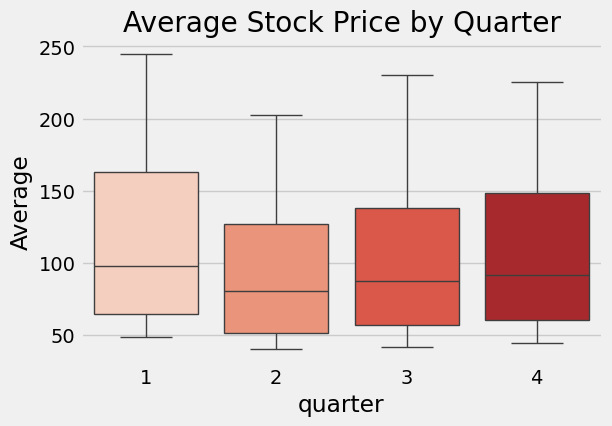

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x='quarter', y='Average', palette='Reds')
ax.set_title('Average Stock Price by Quarter')
plt.show()

/tmp/ipykernel_437/2907801111.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Average', palette='Blues')


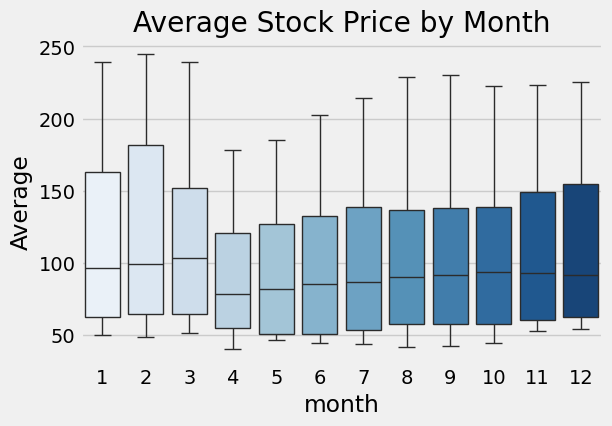

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x='month', y='Average', palette='Blues')
ax.set_title('Average Stock Price by Month')
plt.show()

# Train with Cross Validation

In [14]:
tss = TimeSeriesSplit(n_splits=5, test_size=180, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag6','lag12','lag18']
    TARGET = 'Average'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:59:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1691196807547/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:69.75647	validation_1-rmse:106.93664
[100]	validation_0-rmse:25.79503	validation_1-rmse:40.47744
[200]	validation_0-rmse:9.65952	validation_1-rmse:16.11828
[300]	validation_0-rmse:3.85262	validation_1-rmse:8.03467
[400]	validation_0-rmse:1.94403	validation_1-rmse:6.49678
[500]	validation_0-rmse:1.44630	validation_1-rmse:6.24735
[600]	validation_0-rmse:1.28956	validation_1-rmse:6.22726
[604]	validation_0-rmse:1.28658	validation_1-rmse:6.22807
[21:59:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1691196807547/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:75.28156	validation_1-rmse:131.89340
[100]	validation_0-rmse:27.82572	validation_1-rmse:63.95230
[200]	validation_0-rmse:10.45

In [15]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 26.9217
Fold scores:[6.217132577575022, 18.40673103725426, 32.14314088088534, 45.86048639899682, 31.980825560642906]


# Making a Forecast

In [16]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag6','lag12','lag18']
TARGET = 'Average'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[21:59:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1691196807547/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:119.70781
[100]	validation_0-rmse:44.35497
[200]	validation_0-rmse:16.73548
[300]	validation_0-rmse:6.93457
[400]	validation_0-rmse:3.80963
[499]	validation_0-rmse:2.98452


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

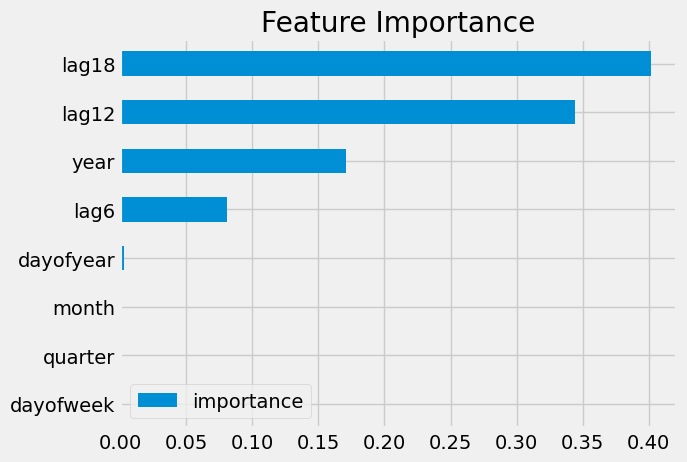

In [17]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [18]:
# Create future dataframe
future = pd.date_range('2021-04-01','2021-10-01', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [19]:
future_w_features = df_and_future.query('isFuture').copy()

In [20]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

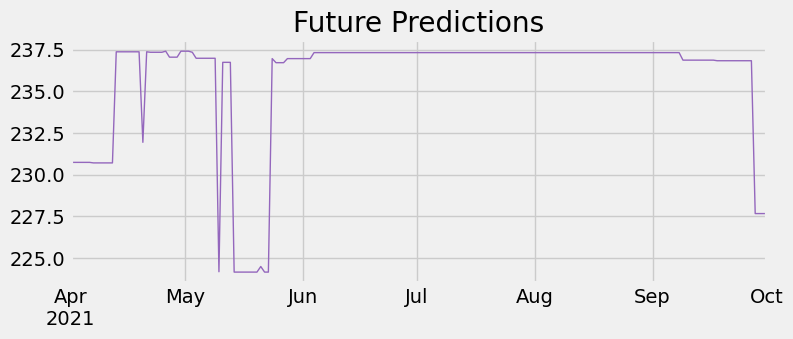

In [21]:
future_w_features['pred'].plot(figsize=(8, 3),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Save Model (as JSON file)

In [22]:
reg.save_model('model.json')